In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")


# Training data preparation 

## See the spots have small expression

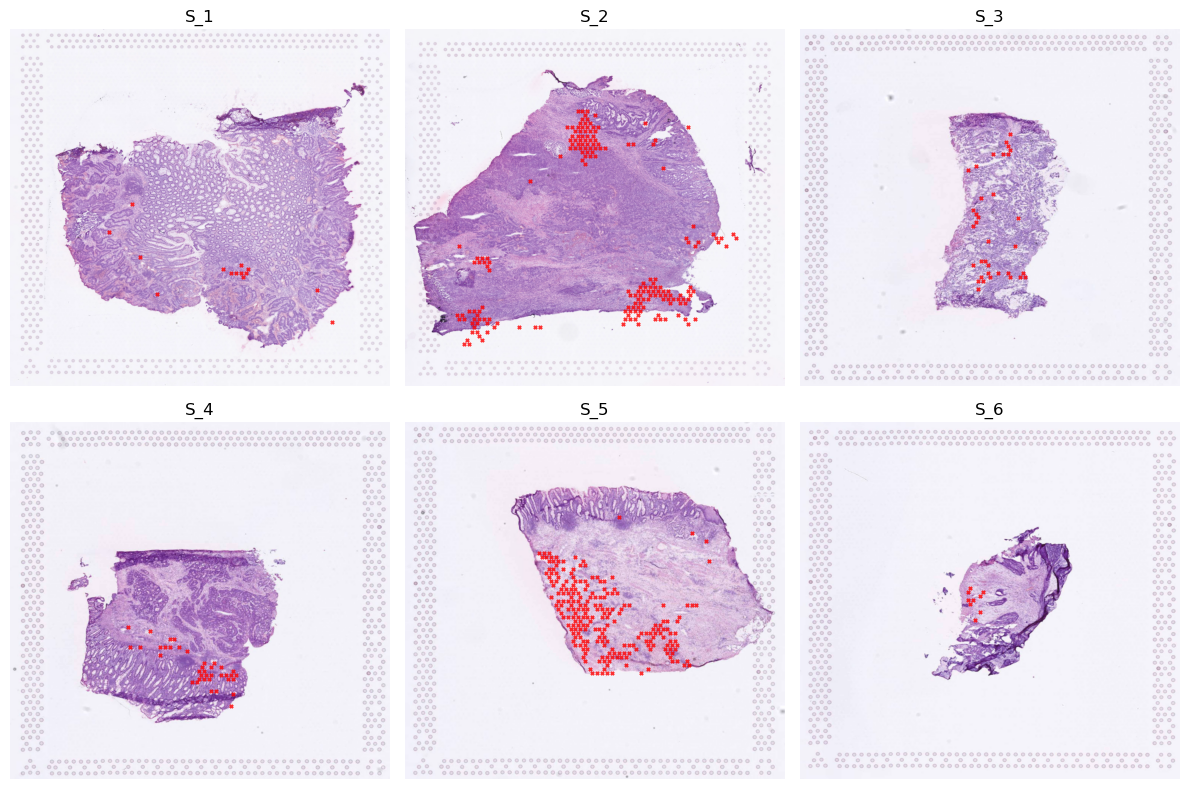

In [11]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Open the HDF5 file and load the Train images and spots datasets
with h5py.File("dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]

    # Get a list of all sample keys (slide identifiers)
    samples = list(train_images.keys())
    n_samples = len(samples)
    
    # Determine grid size (roughly square)
    cols = math.ceil(math.sqrt(n_samples))
    rows = math.ceil(n_samples / cols)
    
    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    # In case there's only one subplot, make it iterable
    axs = axs.flatten() if n_samples > 1 else [axs]
    
    # 在循环之前，先定义你的阈值
    THRESHOLD = 0.2  # 根据需要调整

    # … 省略前面打开 HDF5、grid 布局的部分 …

    for ax, sample in zip(axs, samples):
        image = np.array(train_images[sample])
        spots = np.array(train_spots[sample])
        x, y = spots["x"], spots["y"]

        # 先画所有点
        ax.imshow(image, aspect="auto")
        #ax.scatter(x, y, color="red", s=1, alpha=0.4)

        # --- 新增：标记那些所有 C1–C35 都 < THRESHOLD 的点 ---
        # 1) 找出字段名 C1–C35
        value_fields = [f"C{i}" for i in range(1, 36)]
        # 2) 取出一个 (n_spots,35) 的 array
        values = np.stack([spots[field] for field in value_fields], axis=1)
        # 3) 只要该行所有列都 < threshold，就标记
        mask = np.all(values < THRESHOLD, axis=1)
        # 4) 对应的 x,y
        x_bad = spots["x"][mask]
        y_bad = spots["y"][mask]
        # 5) 画出来
        ax.scatter(x_bad, y_bad, color="red", s=5, marker="x", alpha=0.8)

        ax.axis('off')
        ax.set_title(sample)
        
    # Hide any unused subplots (if the grid is larger than needed)
    for ax in axs[len(samples):]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()


## Quailty of the images

In [4]:
import os
import h5py
import cv2
import numpy as np
import pandas as pd

def image_quality_metrics_nonzero(img):
    """
    Compute QC metrics only over pixels where any channel > 0.
    Returns:
      mean (3,), std (3,), pct_under, pct_over, sharpness, noise_metric
    """
    # 转 float 并归一化到 [0,1]
    img_f = img.astype(np.float32)
    if img_f.max() > 1.5:
        img_f /= img_f.max()

    # 构造 mask：只保留三个通道任意一个 > 0 的像素
    # mask shape: [H, W]
    mask = (img_f > 0).any(axis=2)

    # 提取非零像素的三通道值，shape = [N, 3]
    pix = img_f[mask]

    # 计算 mean / std
    mean = pix.mean(axis=0)
    std  = pix.std(axis=0)

    # under/over-exposed fractions（分母是非零像素总数）
    pct_under = (pix < 10/255).mean()
    pct_over  = (pix > 245/255).mean()

    # 对 sharpness 与 noise，需要先做灰度图，再只计算 mask 区域
    gray_full = cv2.cvtColor((img_f*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray = gray_full.copy()
    gray[~mask] = 0   # 背景(零强度)像素设为 0，忽略它们

    sharp = cv2.Laplacian(gray, cv2.CV_32F).var()
    blur  = cv2.GaussianBlur(gray, (5,5), 0)
    noise = np.abs(gray.astype(np.float32) - blur)[mask].mean()

    return mean, std, pct_under, pct_over, sharp, noise

# --- 批量运行示例 ---
file_path = "dataset/try1_masked.h5"

records = []
with h5py.File(file_path, "r") as h5:
    for split in ["Train", "Test"]:
        imgs = h5[f"images/{split}"]
        for slide_id in imgs.keys():
            img = np.array(imgs[slide_id])
            m, s, u, o, sh, nz = image_quality_metrics_nonzero(img)
            records.append({
                "split": split,
                "slide": slide_id,
                "mean_R": m[0], "mean_G": m[1], "mean_B": m[2],
                "std_R":  s[0], "std_G":  s[1], "std_B":  s[2],
                "pct_underexp": u,
                "pct_overexp":  o,
                "sharpness":    sh,
                "noise_metric": nz
            })

df = pd.DataFrame(records).round(4)
print(df)


   split slide  mean_R  mean_G  mean_B   std_R   std_G   std_B  pct_underexp  \
0  Train   S_1  0.7340  0.6645  0.8120  0.1199  0.1502  0.0881        0.0000   
1  Train   S_2  0.6976  0.6173  0.7894  0.1088  0.1352  0.0833        0.0000   
2  Train   S_3  0.7233  0.6599  0.7851  0.1521  0.1909  0.1028        0.0000   
3  Train   S_4  0.7125  0.6446  0.7797  0.1406  0.1766  0.0960        0.0000   
4  Train   S_5  0.7678  0.7165  0.8137  0.1364  0.1743  0.0869        0.0000   
5  Train   S_6  0.7351  0.6753  0.7992  0.1728  0.2084  0.1241        0.0004   
6   Test   S_7  0.7441  0.6844  0.8008  0.1262  0.1619  0.0817        0.0000   

   pct_overexp    sharpness  noise_metric  
0       0.0104  3012.104248        9.1924  
1       0.0094  2755.958008        9.2902  
2       0.0339  2982.949707       12.0465  
3       0.0211  2864.983887        9.5124  
4       0.0371  2738.248291        8.3697  
5       0.0325  2264.710693       11.9164  
6       0.0194  2579.297119        8.4841  


# Realignment

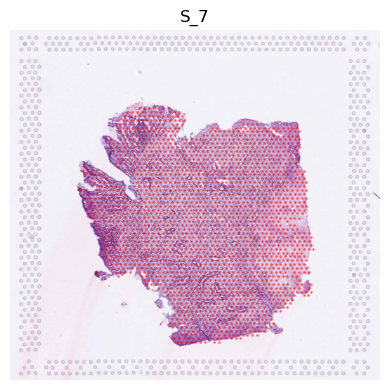

In [14]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Open the HDF5 file and load the Train images and spots datasets
with h5py.File("dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Test"]
    train_spots = h5file["spots/Test"]

    # Get a list of all sample keys (slide identifiers)
    samples = list(train_images.keys())
    n_samples = len(samples)
    
    # Determine grid size (roughly square)
    cols = math.ceil(math.sqrt(n_samples))
    rows = math.ceil(n_samples / cols)
    
    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    # In case there's only one subplot, make it iterable
    axs = axs.flatten() if n_samples > 1 else [axs]
    
    # Loop through each sample and plot the corresponding data
    for ax, sample in zip(axs, samples):
        image = np.array(train_images[sample])
        spots = np.array(train_spots[sample])
        x, y = spots["x"], spots["y"]

        ax.imshow(image, aspect="auto")
        ax.scatter(x, y, color="red", s=1, alpha=0.4)
        ax.axis('off')
        ax.set_title(sample)
        
    # Hide any unused subplots (if the grid is larger than needed)
    for ax in axs[len(samples):]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()


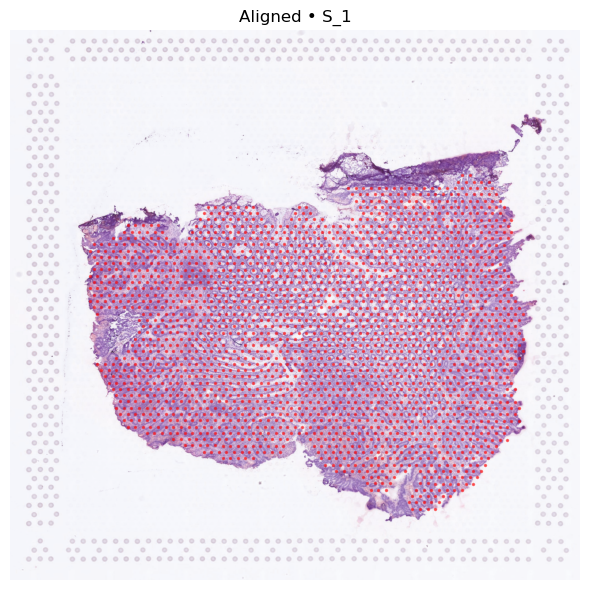

In [12]:
from scripts.realignment import (
    align_and_plot,
    SpotArray
)
import pathlib
import numpy as np
import h5py

# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_1"          # 要顯示的切片
dx, dy            = -55, -60           # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)

# `aligned_spots` 變數現在就握有校正後的座標，可再寫回 HDF5 或做後續分析


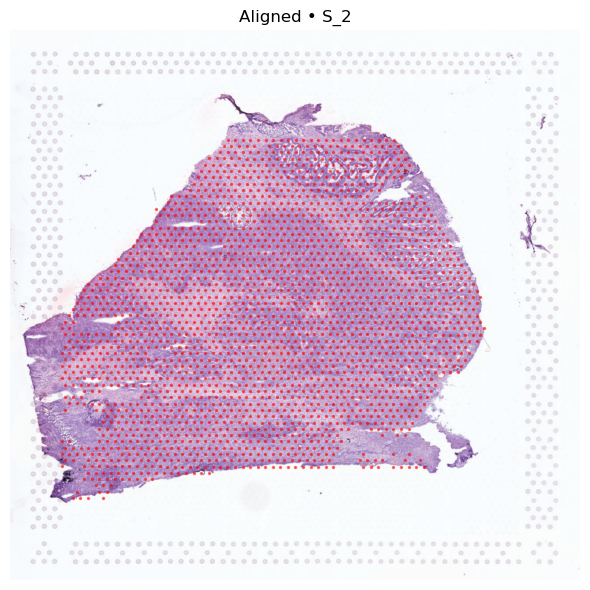

In [13]:
# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_2"          # 要顯示的切片
dx, dy            = -90, -60          # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)


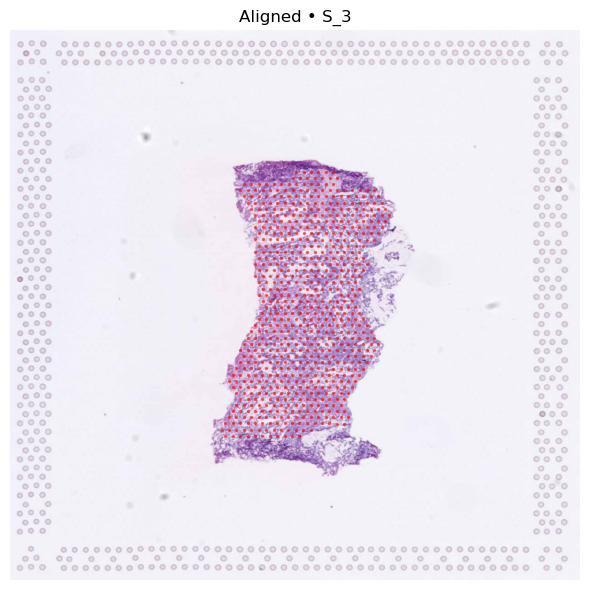

In [33]:
# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_3"          # 要顯示的切片
dx, dy            = -25, -25          # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)


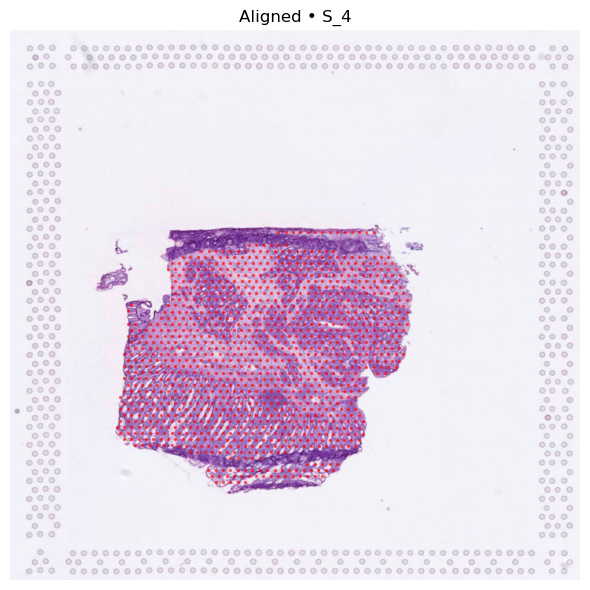

In [41]:
# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_4"          # 要顯示的切片
dx, dy            = -15, -15         # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)


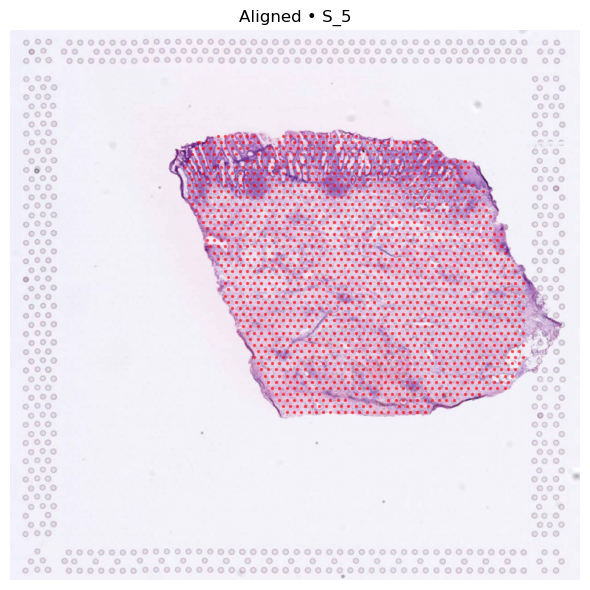

In [42]:
# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_5"          # 要顯示的切片
dx, dy            = -15, -15         # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)


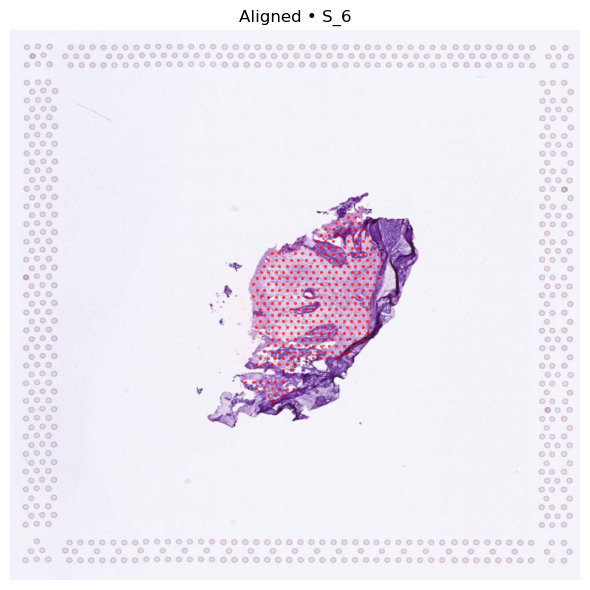

In [37]:
# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_6"          # 要顯示的切片
dx, dy            = -30, -30          # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)


In [ ]:
# ------------------------------------------------------------
# Copy all slides, but translate spots for specified slides only
# ------------------------------------------------------------
from __future__ import annotations
import numpy as np
import h5py
import pathlib

# ---------- Path setup ---------- #
src_h5 = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
dst_h5 = pathlib.Path("./dataset/realign/only_1_v2/original_data.h5")
dst_h5.parent.mkdir(parents=True, exist_ok=True)  # Ensure output directory exists

# ---------- Slide-specific offsets ---------- #
slide_offsets: dict[str, tuple[float, float]] = {
    "S_1": (-55, -60),
    "S_2": (-90, -60),
    "S_3": (-25, -25),
    "S_4": (-15, -15),
    "S_5": (-15, -15),
    "S_6": (-30, -30),
}
# # (Alternatively, only adjust S_1 and S_2)
# slide_offsets = {
#     "S_1": (-55, -60),
#     "S_2": (-90, -60),
# }

# ---------- Read source and write destination ---------- #
with h5py.File(src_h5, "r") as src, h5py.File(dst_h5, "w") as dst:
    img_src  = src["images/Train"]
    spot_src = src["spots/Train"]
    img_dst  = dst.create_group("images/Train")
    spot_dst = dst.create_group("spots/Train")

    # ---- Copy all images ---- #
    for slide in img_src.keys():
        img_dst.create_dataset(
            slide,
            data=np.array(img_src[slide]),
            compression="gzip"
        )

    # ---- Process & copy all spots ---- #
    for slide in spot_src.keys():
        rec = np.array(spot_src[slide])           # structured array
        if slide in slide_offsets:
            dx, dy = slide_offsets[slide]
            rec = rec.copy()                      # avoid modifying source buffer
            rec["x"] = rec["x"] + dx
            rec["y"] = rec["y"] + dy
        spot_dst.create_dataset(
            slide,
            data=rec,
            dtype=rec.dtype,
            compression="gzip"
        )

print(
    "✅ Done! All images and spots have been written to:\n"
    f"   {dst_h5}\n"
    "   (Applied translation to spots for slides: "
    + ", ".join(slide_offsets.keys()) + ")"
)


✅ Done! All images and spots have been written to:
   dataset/try2.h5
   (Applied translation to spots for slides: S_1, S_2, S_3, S_4, S_5, S_6)
